In [97]:
import numpy as np 
import pandas as pd 
import warnings
import csv
import langid
from langdetect import detect
import os 
import spacy
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from spacy.lang.ar import Arabic
from sklearn import preprocessing
import seaborn as sns 
import nltk 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
import re
import string
import matplotlib.cm as cm




## Combine Data

In [35]:
# replace with your folder's path
folder_path = 'C:/Users/rawan/OneDrive/Desktop/NLP/Sentiment-Analysis-for-STC-Arabic-Tweets/Sentiment-Analysis-for-STC-Arabic-Tweets-1/Labeled Data'

all_files = os.listdir(folder_path)

# Filter out non-CSV files
csv_files = [f for f in all_files if f.endswith('.csv')]

# Create a list to hold the dataframes
df_list = []

for csv in csv_files:
    file_path = os.path.join(folder_path, csv)
    try:
        # Try reading the file using default UTF-8 encoding
        df = pd.read_csv(file_path)
        df_list.append(df)
    except UnicodeDecodeError:
        try:
            # If UTF-8 fails, try reading the file using UTF-16 encoding with tab separator
            df = pd.read_csv(file_path, sep='\t', encoding='utf-16')
            df_list.append(df)
        except Exception as e:
            print(f"Could not read file {csv} because of error: {e}")
    except Exception as e:
        print(f"Could not read file {csv} because of error: {e}")

# Concatenate all data into one DataFrame
big_df = pd.concat(df_list, ignore_index=True)

# Save the final result to a new CSV file
big_df.to_csv(os.path.join(folder_path, 'combined_file.csv'), index=False)

In [36]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1)
pd.set_option('display.max_rows', None)

In [37]:
df = pd.read_csv('Labeled Data/combined_file.csv')

In [38]:
df.head(10)

,date,Tweet,label
0,2020-07-24 16:43:37,فیصد آبادی پنجاب دی تے جو کجھ وڈے میاں جی نے کیتا کوی مای دا لال اس پنجاب لئ نہیں کر سکدا مگر اس دے بدلے اسی پنجابیاں نے کی دتا سب توں زیادہ تبدیلی دا کیڑا اس پنجاب نو سی بھانوِیں ایلیٹ کلاس سی یا لویر کلاس یا فیر اسٹیبلشمنٹ سارے پنجابی مستحق اس بربادی دے تے زمہ دار 🙏,0
1,2020-07-24 12:49:02,مرحبا بالامس قمت بطلب عبر تطبيق ماي اس سي لنقل خطي مشغل اخر الى اس سي وصول المندوب وعطاني الشريحه وقالي خلال ساعة تتفعل وحتى الان مرت اكثر مو ساعة وشريحتي بالمشغل القديم تشتغل وشريحتكم ماتشتغل وكلمت المندوب يقول انا مجرد مندوب ماعرف,-1
2,2020-07-23 22:30:45,قائمة الجوالات مو موجوده تطبيق ماي اس سي عشان اطلب,-1
3,2020-07-23 17:10:44,يمكن عنده اعلان حق ماي اس سي وبيطلبه جوال 🤣,0
4,2020-07-23 05:29:11,الافضل عم تجربه تشتري ماي اس سي يوصلونه اين بيتكم والفاتوره ألكترونيه زياده المحلات ب تقريبا,0
5,2020-07-22 20:38:13,ابغى احول مبلغ دولي للعمالة منزليه عندها حساب احول ماي اس سي باي,1
6,2020-07-22 16:19:59,اقسم بالله العظيم يشغلون الخدمة شهر فيك خير حاول تشغلها الشهر الثاني مراسلات ، اتصال ، تويتر ، برنامج ماي اس سي حياة لمن تنادي شركة تعطيك الطعم ، تقضي مقابل خدمة مهترئة حسبي الله ونعم الوكيل فيهم,-1
7,2020-07-22 09:48:46,وقف خدمة الشراء المباشر طريق ماي اس سي,-1
8,2020-07-22 09:18:11,الي اعرفه اغلبية المتاجر نقاط بريال ، ادخلي ماي اس سي وشوفي المتاجر,0
9,2020-07-21 23:18:58,مای تیری پچھلی کتاب تے نہیں وکی چل ھن اغوا تے کتاب لکھ دے۔۔۔ اس سے پیلے اپنئ بھگوڑی گیراج والی مالکن سے ملاقات کر لین,0


In [39]:
df.rename(columns={'label': 'Sentiment'}, inplace=True)


## Dataset Analysis

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       1500 non-null   object
 1   Tweet      1500 non-null   object
 2   Sentiment  1500 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 35.3+ KB


In [41]:
df.isnull().sum()

date         0
Tweet        0
Sentiment    0
dtype: int64

### Drop duplicates and Non-arabic tweet

In [42]:

df = df.drop_duplicates(subset='Tweet', keep='first')


In [52]:
def filter_farsi_tweets(df):
    # Create a new column to store language detection results
    df['language'] = df['Tweet'].apply(detect)

    # Filter the DataFrame to keep only rows with Arabic language
    filtered_df = df[df['language'] == 'ar']

    # Drop the 'language' column since it's no longer needed
    filtered_df.drop('language', axis=1, inplace=True)

    return filtered_df

In [55]:
filtered_df = filter_farsi_tweets(df)

In [56]:
df = filtered_df


In [57]:
df.count()

date         626
Tweet        626
Sentiment    626
dtype: int64

## PreProccessing

In [58]:
punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation

In [59]:
# Arabic stop words with nltk
stop_words = stopwords.words()

In [60]:
arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [66]:
def preprocess(text):
    
    #remove punctuations
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)
    
    # remove Tashkeel
    text = re.sub(arabic_diacritics, '', text)
    
    #remove longation
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    #remove opreating char
    text =re.sub(r'(.)\1+', r'\1',text)

    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)

    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text

In [67]:
df['Tweet'] = df['Tweet'].apply(preprocess)
print(df.head(5))


                  date  \
1  2020-07-24 12:49:02   
2  2020-07-23 22:30:45   
3  2020-07-23 17:10:44   
4  2020-07-23 05:29:11   
5  2020-07-22 20:38:13   

                                                                                                                                                                                                                                 Tweet  \
1  مرحبا بالامس قمت بطلب عبر تطبيق اس سي لنقل خطي مشغل اخر الي اس سي وصول المندوب وعطاني الشريحه وقالي خلال ساعه تفعل وحتي الان مرت اكثر مو ساعه وشريحتي بالمشغل القديم تشتغل وشريحتكم ماتشتغل وكلمت المندوب يقول انا مجرد مندوب ماعرف   
2  قاءمه الجوالات مو موجوده تطبيق اس سي عشان اطلب                                                                                                                                                                                        
3  يمكن عنده اعلان حق اس سي وبيطلبه جوال 🤣                                                                                                   

In [69]:
tokenizer = RegexpTokenizer(r'\w+')
df["Tweet"] = df["Tweet"].apply(tokenizer.tokenize)

In [70]:
df["Tweet"].head(10)


1     [مرحبا, بالامس, قمت, بطلب, عبر, تطبيق, اس, سي, لنقل, خطي, مشغل, اخر, الي, اس, سي, وصول, المندوب, وعطاني, الشريحه, وقالي, خلال, ساعه, تفعل, وحتي, الان, مرت, اكثر, مو, ساعه, وشريحتي, بالمشغل, القديم, تشتغل, وشريحتكم, ماتشتغل, وكلمت, المندوب, يقول, انا, مجرد, مندوب, ماعرف]
2     [قاءمه, الجوالات, مو, موجوده, تطبيق, اس, سي, عشان, اطلب]                                                                                                                                                                                                                      
3     [يمكن, عنده, اعلان, حق, اس, سي, وبيطلبه, جوال]                                                                                                                                                                                                                                
4     [الافضل, عم, تجربه, تشتري, اس, سي, يوصلونه, اين, بيتكم, والفاتوره, الكترونيه, زياده, المحلات, تقريبا]                                                              

In [71]:
stopwords_list = stopwords.words('arabic')

In [72]:
stopwords_list

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [74]:
list_To_Str = ' '.join([str(elem) for elem in stopwords_list]) 


In [75]:
list_To_Str

'إذ إذا إذما إذن أف أقل أكثر ألا إلا التي الذي الذين اللاتي اللائي اللتان اللتيا اللتين اللذان اللذين اللواتي إلى إليك إليكم إليكما إليكن أم أما أما إما أن إن إنا أنا أنت أنتم أنتما أنتن إنما إنه أنى أنى آه آها أو أولاء أولئك أوه آي أي أيها إي أين أين أينما إيه بخ بس بعد بعض بك بكم بكم بكما بكن بل بلى بما بماذا بمن بنا به بها بهم بهما بهن بي بين بيد تلك تلكم تلكما ته تي تين تينك ثم ثمة حاشا حبذا حتى حيث حيثما حين خلا دون ذا ذات ذاك ذان ذانك ذلك ذلكم ذلكما ذلكن ذه ذو ذوا ذواتا ذواتي ذي ذين ذينك ريث سوف سوى شتان عدا عسى عل على عليك عليه عما عن عند غير فإذا فإن فلا فمن في فيم فيما فيه فيها قد كأن كأنما كأي كأين كذا كذلك كل كلا كلاهما كلتا كلما كليكما كليهما كم كم كما كي كيت كيف كيفما لا لاسيما لدى لست لستم لستما لستن لسن لسنا لعل لك لكم لكما لكن لكنما لكي لكيلا لم لما لن لنا له لها لهم لهما لهن لو لولا لوما لي لئن ليت ليس ليسا ليست ليستا ليسوا ما ماذا متى مذ مع مما ممن من منه منها منذ مه مهما نحن نحو نعم ها هاتان هاته هاتي هاتين هاك هاهنا هذا هذان هذه هذي هذين هكذا هل هلا هم هما هن هنا هن

In [77]:
#remove stop word
df["Tweet"] = df["Tweet"].apply(lambda text: [word for word in text if word not in stopwords_list])


In [79]:
y=df['Sentiment']
y.value_counts()

Sentiment
 0    319
-1    214
 1    93 
Name: count, dtype: int64

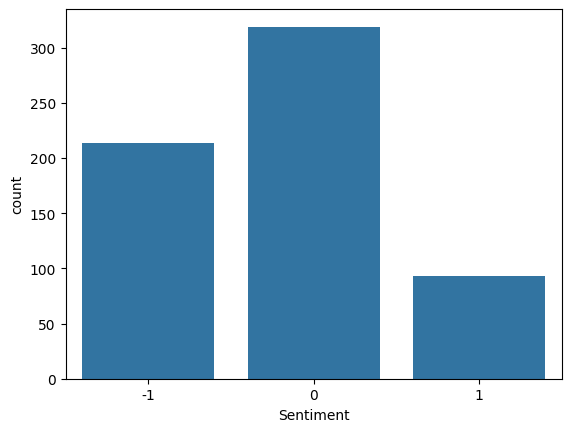

In [84]:

sns.countplot(data= df, x = "Sentiment")
plt.show()

## Feature Extraction

In [121]:
# Initialize the TfidfVectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features=10000
)


In [122]:
unigramdataGet = word_vectorizer.fit_transform(df['Tweet'].astype('str'))
unigramdataGet = unigramdataGet.toarray()

In [124]:
vocab = word_vectorizer.get_feature_names_out()

In [125]:
unigramdata_features = pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)

In [126]:

unigramdata_features[unigramdata_features > 0] = 1

In [128]:

# Print the first few rows of the DataFrame
unigramdata_features.head()

apk  dsl  esim  ksa  mystc  mystcبتشوفي  stc  stcماعندي  stcمالحل  widgets  \
0  0.0  0.0  0.0   0.0  0.0    0.0          0.0  0.0        0.0       0.0       
1  0.0  0.0  0.0   0.0  0.0    0.0          0.0  0.0        0.0       0.0       
2  0.0  0.0  0.0   0.0  0.0    0.0          0.0  0.0        0.0       0.0       
3  0.0  0.0  0.0   0.0  0.0    0.0          0.0  0.0        0.0       0.0       
4  0.0  0.0  0.0   0.0  0.0    0.0          0.0  0.0        0.0       0.0       

    xr   اب  ابد  ابدله  ابديت  ابرزها  ابشر  ابصم  ابعد  ابغا  ابغاك  ابغاها  \
0  0.0  0.0  0.0  0.0    0.0    0.0     0.0   0.0   0.0   0.0   0.0    0.0      
1  0.0  0.0  0.0  0.0    0.0    0.0     0.0   0.0   0.0   0.0   0.0    0.0      
2  0.0  0.0  0.0  0.0    0.0    0.0     0.0   0.0   0.0   0.0   0.0    0.0      
3  0.0  0.0  0.0  0.0    0.0    0.0     0.0   0.0   0.0   0.0   0.0    0.0      
4  0.0  0.0  0.0  0.0    0.0    0.0     0.0   0.0   0.0   0.0   0.0    0.0      

   ابغي  ابل  ابلغ  ابلكيشن  ابو  ابوه  ابي  ابيه  اتحكم  اتخلص  اتصال  \
0  0.0   0.0  0.0   0.0      0.0  0.0   0.0  0.0   0.0    0.0    0.0     
1  0.0   0.0  0.0   0.0      0.0  0.0   0.0  0.0   0.0    0.0    0.0     
2  0.0   0.0  0.0   0.0      0.0  0.0   0.0  0.0   0.0    0.0    0.0     
3  0.0   0.0  0.0   0.0      0.0  0.0   0.0  0.0   0.0    0.0    0.0     
4  1.0   0.0  0.0   0.0      0.0  0.0   0.0  0.0   0.0    0.0    0.0     

   اتصالات  اتصالاتك  اتصالي  اتصل  اتصلت  اتعامل  اتفاجاء  اتقدم  اتكلم  \
0  0.0      0.0       0.0     0.0   0.0    0.0     0.0      0.0    0.0     
1  0.0      0.0       0.0     0.0   0.0    0.0     0.0      0.0    0.0     
2  0.0      0.0       0.0     0.0   0.0    0.0     0.0      0.0    0.0     
3  0.0      0.0       0.0     0.0   0.0    0.0     0.0      0.0    0.0     
4  0.0      0.0       0.0     0.0   0.0    0.0     0.0      0.0    0.0     

   اتمام  اتمني  اتواصل  اتواصلت  اتوجه  اتوقع  اجابه  اجبرنا  اجتماعي  اجتمع  \
0  0.0    0.0    0.0     0.0      0.0    0.0    0.0    0.0     0.0      0.0     
1  0.0    0.0    0.0     0.0      0.0    0.0    0.0    0.0     0.0      0.0     
2  0.0    0.0    0.0     0.0      0.0    0.0    0.0    0.0     0.0      0.0     
3  0.0    0.0    0.0     0.0      0.0    0.0    0.0    0.0     0.0      0.0     
4  0.0    0.0    0.0     0.0      0.0    0.0    0.0    0.0     0.0      0.0     

   اجد  اجده  اجدها  اجرب  اجل  اجهاز  اجهزتكم  اجهزه  اجوبه  اجور  اجي  \
0  0.0  0.0   0.0    0.0   0.0  0.0    0.0      0.0    0.0    0.0   0.0   
1  0.0  0.0   0.0    0.0   0.0  0.0    0.0      0.0    0.0    0.0   0.0   
2  0.0  0.0   0.0    0.0   0.0  0.0    0.0      0.0    0.0    0.0   0.0   
3  0.0  0.0   0.0    0.0   0.0  0.0    0.0      0.0    0.0    0.0   0.0   
4  0.0  0.0   0.0    0.0   0.0  0.0    0.0      0.0    0.0    0.0   0.0   

   احاول  احب  احتاج  احتاجو  احجز  احد  احدث  احذفه  احس  احسب  احسن  احصل  \
0  0.0    0.0  0.0    0.0     0.0   0.0  0.0   0.0    0.0  0.0   0.0   0.0    
1  0.0    0.0  0.0    0.0     0.0   0.0  0.0   0.0    0.0  0.0   0.0   0.0    
2  0.0    0.0  0.0    0.0     0.0   0.0  0.0   0.0    0.0  0.0   0.0   0.0    
3  0.0    0.0  0.0    0.0     0.0   0.0  0.0   0.0    0.0  0.0   0.0   0.0    
4  0.0    0.0  0.0    0.0     0.0   0.0  0.0   0.0    0.0  0.0   0.0   0.0    

   احصلها  احضر  احل  احلامي  احمل  احنا  احول  احوله  احولها   اخ  اخاف  \
0  0.0     0.0   0.0  0.0     0.0   0.0   0.0   0.0    0.0     0.0  0.0    
1  0.0     0.0   0.0  0.0     0.0   0.0   0.0   0.0    0.0     0.0  0.0    
2  0.0     0.0   0.0  0.0     0.0   0.0   0.0   0.0    0.0     0.0  0.0    
3  0.0     0.0   0.0  0.0     0.0   0.0   0.0   0.0    0.0     0.0  0.0    
4  0.0     0.0   0.0  0.0     0.0   0.0   1.0   0.0    0.0     0.0  0.0    

   اخبث  اخبرني  اختابرات  اختاره  اختبارات  اختراعات  اختي  اختيار  اخذ  \
0  0.0   0.0     0.0       0.0     0.0       0.0       0.0   0.0     0.0   
1  0.0   0.0     0.0       0.0     0.0       0.0       0.0   0.0     0.0   
2  0.0   0.0     0.0       0.

In [129]:
y=df['Sentiment']
X=unigramdata_features